In [1]:
import cv2
from matplotlib import pyplot as plt
import solid as sp
import viewscad
import random
from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder

In [2]:
from datetime import datetime, timedelta
start = datetime.utcnow()

In [3]:
ProjectName = "LycodonTop"
LayerFile = f"Downloads/{ProjectName}.png"
TraceFile = f"Downloads/{ProjectName}Trace.png"
TrenchFile = "Downloads/LycodonDrill.png"

In [4]:
img_files = [LayerFile, TraceFile, TrenchFile]
images = {img_file: cv2.imread(img_file, cv2.IMREAD_GRAYSCALE) for img_file in img_files}

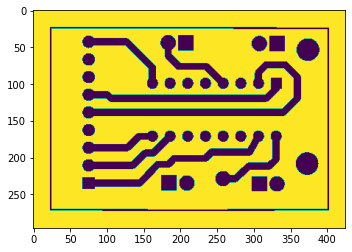

In [5]:
plt.imshow(images[LayerFile])

In [6]:
def get_image_grid_fill_map(img):
    height, width = img.shape
    filled = {}
    img_grid = [[0 for x in range(width + 1)] for y in range(height + 1)]
    count = 0
    for y_i, y in enumerate(img):
        col = img_grid[y_i]
        for x_i, x in enumerate(y):
            count += 1
            if x < 125:
                col[x_i] = 1
                filled[(x_i, y_i)] = 1
    return filled, img_grid, (height, width)

In [7]:
_, trace_grid, _ = get_image_grid_fill_map(images[TraceFile])
trace_grid = Grid(matrix=trace_grid)
layer_filled, _, layer_shape = get_image_grid_fill_map(images[LayerFile])

In [8]:
def shape_mapper(node, shape=[]):
   shape.extend([node])
   [shape_mapper(n, shape) for n in trace_grid.neighbors(node, diagonal_movement=True) if n not in shape]
   return shape

In [9]:
import sys
sys.setrecursionlimit(int((layer_shape[0] * layer_shape[1]) / 4))

In [10]:
shapes = []
all_nodes = []
for row in trace_grid.nodes:
    for node in row:
        if not node.walkable:
            continue
        all_nodes.append(node)
        matched = False
        for shape in shapes:
            if node in shape:
                matched = True
                break
        if matched:
            continue
        else:
            shapes.append(shape_mapper(node, []))
print(len(all_nodes))
print(len(shapes))

13114
8


In [11]:
def empty_space(node):
    space = 0
    paths = trace_grid.neighbors(node)
    while True:
        if space > 5:
            break
        elif len(paths) == 4:
            space += 1
        else:
            space += len(paths) / 4
            break
        paths = [sn for n in paths for sn in trace_grid.neighbors(n)
                 if (sn.x == node.x) != (sn.y == node.y)]
    return space

In [12]:
selected = []
for shape in shapes:
    shape_space = [(n, empty_space(n)) for n in shape]
    max_space  = max(shape_space, key=lambda x: x[1])[1]
    if max_space <= 4:
        max_node = max(shape_space, key=lambda x: x[1])[0]
    else:
        max_nodes = [n for n, es in shape_space if es > 4]
        max_node = random.sample(max_nodes, k=1)[0]
    selected.append(max_node)

In [13]:
tower_coords = [[n.x, n.y] for n in selected]
len(tower_coords)

8

In [14]:
tower_height = 16
space = None
cuber = lambda: sp.cube(size=[1, 1, 2], center=True)
normal_placer = lambda coord: sp.translate([coord[0], coord[1], 0])

tower = lambda: sp.cube(size=[3, 4, tower_height], center=True)
tower_placer = lambda coord: sp.translate([coord[0], coord[1], tower_height / 2])


def in_tower_coords(coord):
    for tc in tower_coords:
        if coord[0] == tc[0] and coord[1] == tc[1]:
            return True
    return False

for coord in layer_filled.keys():
    coord_space = tower_placer(coord)(tower()) \
                  if in_tower_coords(coord) else \
                  normal_placer(coord)(cuber())
    if space is None:
        space = coord_space
    else:
        space += coord_space

In [15]:
# borders = sp.cube(size=[layer_shape[1], 1, 3], center=False)
# borders += normal_placer([0, layer_shape[0], 0])(sp.cube(size=[layer_shape[1], 1, 3], center=False))
# borders += normal_placer([0, 0, 0])(sp.cube(size=[1, layer_shape[0], 3], center=False))
# borders += normal_placer([layer_shape[1], 0, 0])(sp.cube(size=[1, layer_shape[0], 3], center=False))

In [16]:
# pcb = space + borders

In [17]:
r = viewscad.Renderer()
r.render(space)

In [18]:
sp.scad_render_to_file(space, f"{ProjectName}.scad")
stlf = f"{ProjectName}.stl"
scadf = f"{ProjectName}.scad"
!openscad -o $stlf $scadf

In [19]:
end = datetime.utcnow()
print((end - start).total_seconds() / 60)

16.396706066666667
